

# **Congressional Resignations Over Time**




Bridget Grossman

https://bgg999.github.io/

---



#Project Goals

The project goal is to investigate congressional resignations. Have congressional resignations changed over time? I would like to know if there are any patterns to resignation and whether congressional resignation is varies based on age, gender, state, and more. Knowing how congressional resignations have changed over time and can give insight on how the country and the government has changed over time. I would also like to know if it's possible to predict party based on resignation data.

#ETL Congressional Resignations Data

I found this data from the fivethirtyeight github site (https://github.com/fivethirtyeight/data/tree/master/congress-resignations). It was used in this article: https://fivethirtyeight.com/features/more-people-are-resigning-from-congress-than-at-any-time-in-recent-history/. The data contains informaton on all congress member resignations from 1901 to 2018. The data contains 615 entries. The data was pretty tidy to begin with, so there was not much I had to do. I checked that all of the variables had the correct dtype, and there was one that didn't so I fixed it.

In [1]:
%cd /content
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')
congressional_resignations_df = pd.read_csv("/content/drive/MyDrive/CS_Project/congressional_resignations.csv")

congressional_resignations_df.head()

congressional_resignations_df.dtypes

congressional_resignations_df["Resignation Date"] = pd.to_datetime(congressional_resignations_df["Resignation Date"])



/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I also made the categories easier to understand.

In [2]:
congressional_resignations_tidy_df = congressional_resignations_df.copy()

congressional_resignations_tidy_df["Category"] = congressional_resignations_tidy_df["Category"].str.strip()


congressional_resignations_tidy_df["Category"] = congressional_resignations_tidy_df["Category"].map({
    "X":"Unwanted sexual contact",
    "A":"Consensual sex scandals",
    "B":"Other scandals",
    "C":"Other office",
    "D":"Private sector",
    "E":"Health/family",
    "F":"Other",
    "G":"Left early",
    "H":"Military service",
    "I":"Election overturned",
    "C & F": "Other office and Other",
    "B & C" : "Other scandals and Other office",
    "B & D": "Other scandals and Private sector",
    "B & G": "Other scandals and Left early",
    "B & E": "Other scandals and Health/Family",
    "D & F": "Private sector and Other",
    "D & G": "Private sector and Left early",
    "D & E": "Private sector and Health/Family",
    "E & F": "Health/Family and Other",
    "E & G": "Health/Family and Left early",
    "F & G": "Other and Left early",
}).fillna("Unknown Category")

congressional_resignations_tidy_df["Category"]

congressional_resignations_tidy_df.head()



,Member,Party,District,Congress,Resignation Date,Reason,Source,Category
0,Pat Tiberi,R,OH-12,115th,2018-01-15,Took a job with the Ohio Business Roundtable,New York Times,Private sector
1,Al Franken,D,MN-SEN,115th,2018-01-02,Sexual harassment/groping/unwanted kissing,Minneapolis Star Tribune,Unwanted sexual contact
2,Trent Franks,R,AZ-08,115th,2017-12-08,Sexual harassment/surrogacy pressure,CNN,Unwanted sexual contact
3,John Conyers,D,MI-13,115th,2017-12-05,Sexual harassment/inappropriate touching,Washington Post,Unwanted sexual contact
4,Tim Murphy,R,PA-18,115th,2017-10-21,Extramarital affair/abortion hypocrisy,POLITICO,Consensual sex scandals


#ETL Congress Dataset

This dataset I found on github contains all congress members throughout US history (https://github.com/unitedstates/congress-legislators/blob/main/legislators-historical.yaml). I found the data in yaml format. I later realized that the csv was also available, but not until after I had already figured out how to transfer it from yaml format into a pandas dataframe. This dataset contains gender information, birthday information, and information on the terms of each member of congress. This is useful for helping me investigate the impact of age, experience, and gender on resignations.


In [3]:
import yaml
with open("/content/drive/MyDrive/CS_Project/legislators-historical.yaml", "r") as congress:
  legislators_historical = yaml.safe_load(congress)

records = []



for person in legislators_historical:
  terms =  person.get("terms", [])


  num_terms = len(terms)
  end_term_date = terms[-1]["end"] if terms else none

  record = {
  "Wikipedia Name": person["id"].get("wikipedia"),
  "First Name": person["name"].get("first"),
  "Last Name":person["name"].get("last"),
  "Middle Name": person["name"].get("middle", ""),
  "Suffix": person["name"].get("suffix", ""),
  "Birthday": person["bio"].get("birthday"),
  "Gender": person["bio"].get("gender"),
  "Num Terms": num_terms,
  "End Term Date": end_term_date
  }

  records.append(record)

legislators_df = pd.DataFrame(records)
legislators_df.head()





,Wikipedia Name,First Name,Last Name,Middle Name,Suffix,Birthday,Gender,Num Terms,End Term Date
0,Richard Bassett (Delaware politician),Richard,Bassett,,,1745-04-02,M,1,1793-03-03
1,Theodorick Bland (congressman),Theodorick,Bland,,,1742-03-21,M,1,1791-03-03
2,Aedanus Burke,Aedanus,Burke,,,1743-06-16,M,1,1791-03-03
3,Daniel Carroll,Daniel,Carroll,,,1730-07-22,M,1,1791-03-03
4,George Clymer,George,Clymer,,,1739-03-16,M,1,1791-03-03


My first step in tidying the data was to look at the dtypes of all of the variables. They all seemed correct except for the birthday and end_term_date variables. Those were in object format, but they should have been in datetime format.

In [4]:
legislators_df.dtypes

,0
Wikipedia Name,object
First Name,object
Last Name,object
Middle Name,object
Suffix,object
Birthday,object
Gender,object
Num Terms,int64
End Term Date,object


I then fixed the dtype for birthday and end_term_date

In [5]:
legislators_df["End Term Date"] = pd.to_datetime(legislators_df["End Term Date"])
legislators_df["Birthday"] = pd.to_datetime(legislators_df["Birthday"])
legislators_df.dtypes

,0
Wikipedia Name,object
First Name,object
Last Name,object
Middle Name,object
Suffix,object
Birthday,datetime64[ns]
Gender,object
Num Terms,int64
End Term Date,datetime64[ns]


I was planning to use wikipedia name from the legislators dataset to merge with the congressional resignations dataset, because the wikipedia name seemed to be closest to the names used in the congressional resignations dataset. I noticed that wikipedia names sometimes had words in parantheses at the end that would mess up the merge, so I had to make sure to remove those. I also wanted to clean wikipedia_name and Member so that they would be closer to each other and better for the merge. I removed periods and extra spaces.

I also squished them both because I was having issues with spacing in between initials.

In [6]:
import re

def clean_names(name):
  if pd.isnull(name):
    return ""
  name = re.sub(r"\([^()]*\)", "", name)
  name = re.sub(r"[.,]", "", name)
  name = re.sub(r"\s+", " ", name)

  return name.strip()


legislators_df["Name Cleaned"] = legislators_df["Wikipedia Name"].apply(clean_names)
congressional_resignations_tidy_df["Member Cleaned"] = congressional_resignations_tidy_df["Member"].apply(clean_names)

legislators_df["Name Squished"] = legislators_df["Name Cleaned"].str.replace(" ", "")
congressional_resignations_tidy_df["Member Squished"] = congressional_resignations_tidy_df["Member Cleaned"].str.replace(" ", "")



I was having trouble getting matches with my merge, so I installed rapidfuzz so I could get matches when the names were close to each other. You can learn more about rapidfuzz at https://pypi.org/project/RapidFuzz/ or https://github.com/rapidfuzz/RapidFuzz .

In [7]:

!pip install rapidfuzz

from rapidfuzz import process
from rapidfuzz import fuzz


def get_match(name, choices, threshold = 75):
  match = process.extractOne(name, choices, scorer=fuzz.token_set_ratio)
  return match[0] if match and match[1] >= threshold else None

legislators_df["Name Match"] = legislators_df["Name Squished"].apply(lambda x: get_match(x, congressional_resignations_tidy_df["Member Squished"]))



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.1 MB/s eta 0:00:00


My next step was to merge and make sure that the fuzzy matches were correct by ensuring that the resignation year and the end term year from the separate datasets were within 1 year.  

In [8]:

legislators_df["End Term Year"] = legislators_df["End Term Date"].dt.year

congressional_resignations_tidy_df["Resignation Year"] = congressional_resignations_tidy_df["Resignation Date"].dt.year

congressional_resignations_tidy_df.describe()

legislators_df.describe()

legislators_df["Wikipedia Name"].count()

merged = legislators_df.merge(congressional_resignations_tidy_df, how = "inner", left_on = ["Name Match"], right_on = ["Member Squished"])

matched_names = legislators_df["Name Match"].dropna().unique()

merged_flex_year = merged[
    (merged["End Term Year"].notnull()) &
    (merged["Resignation Year"].notnull()) &
    (abs(merged["End Term Year"] - merged["Resignation Year"]) <= 1)
]



I then limited my dataframe to only the columns that I needed to make it more tidy.

In [9]:

merged_df = merged_flex_year[["Name Cleaned", "Member", "District", "Congress", "Resignation Date", "Resignation Year","End Term Year", "End Term Date", "Party", "Birthday", "Gender", "Num Terms", "Reason", "Source", "Category"]]

merged_df

,Name Cleaned,Member,District,Congress,Resignation Date,Resignation Year,End Term Year,End Term Date,Party,Birthday,Gender,Num Terms,Reason,Source,Category
937,Joseph R Burton,Joseph Burton,KS-SEN,59th,1906-06-04,1906,1907,1907-03-03,R,1852-11-16,M,1,Convicted of corruption,U.S. Senate,Other scandals
942,S W T Lanham,S.W.T. Lanham,TX-08,57th,1903-01-15,1903,1903,1903-03-03,D,1846-07-04,M,8,Elected Texas governor,U.S. Congress,Other office
946,William Henry Moody,William Moody,MA-06,57th,1902-05-01,1902,1903,1903-03-03,R,1853-12-23,M,4,Appointed to Roosevelt administration,U.S. Congress,Other office
948,George W Ray,George Ray,NY-26,57th,1902-09-11,1902,1903,1903-03-03,R,1844-02-03,M,7,Appointed federal judge,U.S. Congress,Other office
963,Charles W Fairbanks,Charles Fairbanks,IN-SEN,58th,1905-03-03,1905,1905,1905-12-31,R,1852-05-11,M,2,Elected vice president,U.S. Congress,Other office
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,Tim Murphy,Tim Murphy,PA-18,115th,2017-10-21,2017,2017,2017-10-21,R,1952-09-11,M,8,Extramarital affair/abortion hypocrisy,POLITICO,Consensual sex scandals
2101,John Conyers,John Conyers,MI-13,115th,2017-12-05,2017,2017,2017-12-05,D,1929-05-16,M,27,Sexual harassment/inappropriate touching,Washington Post,Unwanted sexual contact
2102,Trent Franks,Trent Franks,AZ-08,115th,2017-12-08,2017,2017,2017-12-08,R,1957-06-19,M,8,Sexual harassment/surrogacy pressure,CNN,Unwanted sexual contact
2103,Al Franken,Al Franken,MN-SEN,115th,2018-01-02,2018,2018,2018-01-02,D,1951-05-21,M,2,Sexual harassment/groping/unwanted kissing,Minneapolis Star Tribune,Unwanted sexual contact


#EDA

258/615 resignations have been Republican, and 357/615 have been Democrats. Part of what I was interested in was the difference between political parties. This shows me that democrats have around 100 more resignations since 1901 than republicans.

In [10]:
congressional_resignations_tidy_df[congressional_resignations_tidy_df["Party"] == "R"]
num_republicans_resigned = congressional_resignations_tidy_df[congressional_resignations_tidy_df["Party"] == "R"]["Party"].value_counts()

#258 Republicans have resigned

congressional_resignations_tidy_df[congressional_resignations_tidy_df["Party"] == "D"]
congressional_resignations_tidy_df[congressional_resignations_tidy_df["Party"] == "D"]["Party"].value_counts()

#357 Democrats have resigned


,count
Party,
D,357


357 resignations were because the congressperson was moving to another office. This was the most common reason for resigning. THe next most common category was leaving early. Other scandals appeared 30 times, unwanted sexual contact appeared 8 times, consensual sex scandals also appeared 8 times. Looking at the value counts of the categories allows me to get to know the data better and look at what is common and what is not common. I get to see how many times each of the scandalous categories appeared. This can help me answer my questions.

In [11]:
congressional_resignations_tidy_df["Category"].value_counts()

,count
Category,
Other office,357
Left early,87
Private sector,50
Other scandals,30
Election overturned,20
Health/family,15
Military service,13
Other,10
Consensual sex scandals,8


Of the 8 resignations that were due to unwanted sexual contact, 5 were from democrats, and 3 were from republicans.

In [12]:
congressional_resignations_tidy_df[(congressional_resignations_tidy_df["Party"] == "R") & (congressional_resignations_tidy_df["Category"] == "Unwanted sexual contact")]
congressional_resignations_tidy_df[(congressional_resignations_tidy_df["Party"] == "D") & (congressional_resignations_tidy_df["Category"] == "Unwanted sexual contact")]


,Member,Party,District,Congress,Resignation Date,Reason,Source,Category,Member Cleaned,Member Squished,Resignation Year
1,Al Franken,D,MN-SEN,115th,2018-01-02,Sexual harassment/groping/unwanted kissing,Minneapolis Star Tribune,Unwanted sexual contact,Al Franken,AlFranken,2018
3,John Conyers,D,MI-13,115th,2017-12-05,Sexual harassment/inappropriate touching,Washington Post,Unwanted sexual contact,John Conyers,JohnConyers,2017
39,David Wu,D,OR-01,112th,2011-08-03,Sexual harassment/sex with teenage girl,The Oregonian,Unwanted sexual contact,David Wu,DavidWu,2011
48,Eric Massa,D,NY-29,111th,2010-03-08,Sexual harassment/groping (same-sex),The Week,Unwanted sexual contact,Eric Massa,EricMassa,2010
105,Mel Reynolds,D,IL-02,104th,1995-10-01,Convicted of sex with 16-year-old girl,New York Times,Unwanted sexual contact,Mel Reynolds,MelReynolds,1995


I made a bar chart with the different categories and the amount of times each one appeared. I used the slightly less tidy data, with the letters for the category labels because it made coding the chart easier for me. This chart helps you visualise which categories are more common.

Text(0, 0.5, 'Number of Resignations')

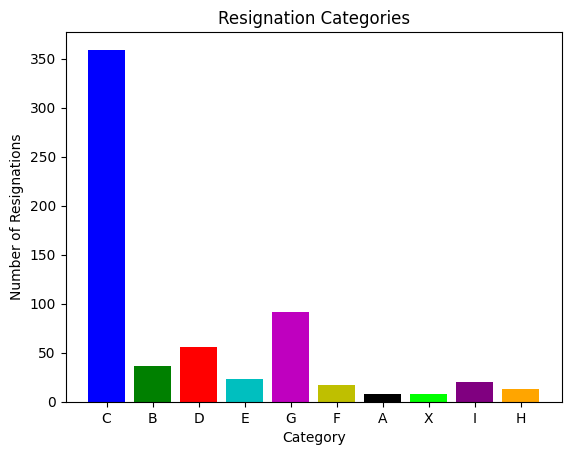

In [13]:
congressional_resignations_df["Category"] = congressional_resignations_df["Category"].str.strip()

cat_c = (congressional_resignations_df["Category"] == "C") |(congressional_resignations_df["Category"] == "C & F") | (congressional_resignations_df["Category"] == "B & C")

cat_b = (congressional_resignations_df["Category"] == "B") |(congressional_resignations_df["Category"] == "B & D") | (congressional_resignations_df["Category"] == "B & G")| (congressional_resignations_df["Category"] == "B & E")| (congressional_resignations_df["Category"] == "B & C")

cat_d = (congressional_resignations_df["Category"] == "D") |(congressional_resignations_df["Category"] == "D & F") | (congressional_resignations_df["Category"] == "D & G") | (congressional_resignations_df["Category"] == "B & D") | (congressional_resignations_df["Category"] == "D & E")

cat_e = (congressional_resignations_df["Category"] == "E") |(congressional_resignations_df["Category"] == "E & F") | (congressional_resignations_df["Category"] == "E & G") | (congressional_resignations_df["Category"] == "B & E") | (congressional_resignations_df["Category"] == "D & E")

cat_g = (congressional_resignations_df["Category"] == "G") | (congressional_resignations_df["Category"] == "F & G")| (congressional_resignations_df["Category"] == "E & G")| (congressional_resignations_df["Category"] == "B & G") | (congressional_resignations_df["Category"] == "D & G")

cat_f = (congressional_resignations_df["Category"] == "F") |(congressional_resignations_df["Category"] == "F & G") | (congressional_resignations_df["Category"] == "E & F") | (congressional_resignations_df["Category"] == "D & F") | (congressional_resignations_df["Category"] == "C & F")

cat_c_counts = cat_c.sum()

cat_b_counts = cat_b.sum()
cat_d_counts = cat_d.sum()

cat_e_counts = cat_e.sum()

cat_g_counts = cat_g.sum()

cat_f_counts = cat_f.sum()

cat_x_counts = (congressional_resignations_df["Category"] == "X").sum()

cat_i_counts = (congressional_resignations_df["Category"] == "I").sum()

cat_h_counts = (congressional_resignations_df["Category"] == "H").sum()
cat_a_counts = (congressional_resignations_df["Category"] == "A").sum()


categories = ["C", "B", "D", "E", "G", "F", "A", "X", "I", "H"]
counts = [cat_c_counts, cat_b_counts, cat_d_counts, cat_e_counts, cat_g_counts, cat_f_counts, cat_a_counts, cat_x_counts, cat_i_counts, cat_h_counts]

colors = ["b", "g", "r", "c", "m", "y", "k", "lime", "purple", "orange"]

plt.bar(categories, counts, color = colors)
plt.title("Resignation Categories")
plt.xlabel("Category")
plt.ylabel("Number of Resignations")



I also made a chart that shows how resignations changed over time. The chart shows that there was a large a large amount of resignations at around mid-1970's. This chart shows me how the amount of resignations has changed over time.

Text(0, 0.5, 'Number of Resignations')

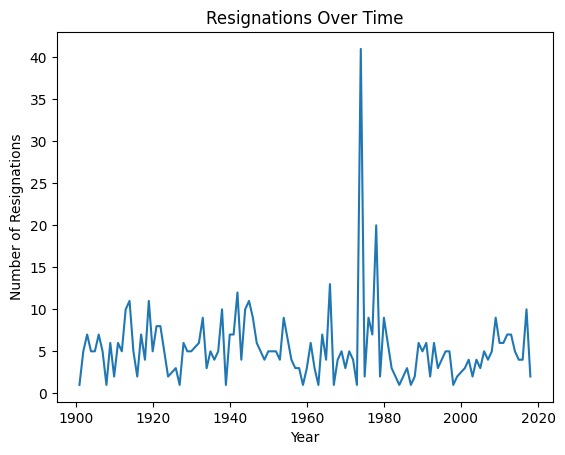

In [14]:
congressional_resignations_tidy_df["Resignation Year"] = congressional_resignations_tidy_df["Resignation Date"].dt.year
congressional_resignations_tidy_df["Resignation Year"] = pd.to_numeric(congressional_resignations_tidy_df["Resignation Year"])
year_counts = congressional_resignations_tidy_df["Resignation Year"].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values)
plt.title("Resignations Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Resignations")

I then made a graph of resignations over time but with separate lines for democrats and republicans, so that we could compare the two. It seems like when resignations for one party goes down, it goes up for the other. The most resignations were from Republicans in the 1970's.

Text(0.5, 1.0, 'Resignations per Year')

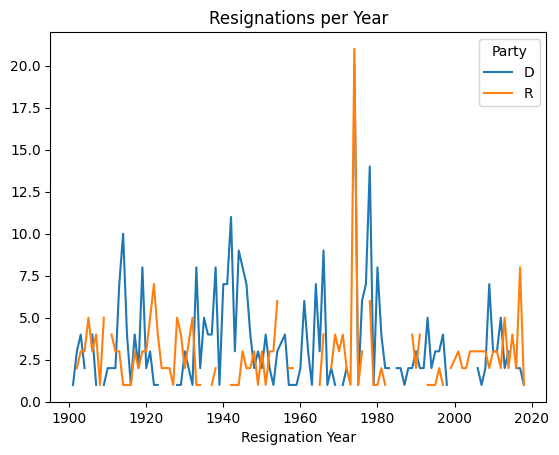

In [15]:
party_year_groupby = congressional_resignations_tidy_df.groupby(["Resignation Year", "Party"])
party_year_groupby.size().unstack().plot()
plt.title("Resignations per Year")

I then found what year exactly the most resisngations occured in. The most resignations occured in 1974, which is around when watergate occured. You can learn about watergate at https://www.fbi.gov/history/famous-cases/watergate.

In [16]:
year_counts = congressional_resignations_tidy_df["Resignation Year"].value_counts()
most_common_year = year_counts.idxmax()

print(most_common_year)


1974


After merging datasets and having access to the data on gender, I checked to see how resignations varied by gender. Men have resigned way more than women, but that makes sense considering women were not even allowed to vote until the 19th amendment. That's why I'm going to look at how resignations changed overtime by gender.

<Axes: xlabel='Gender'>

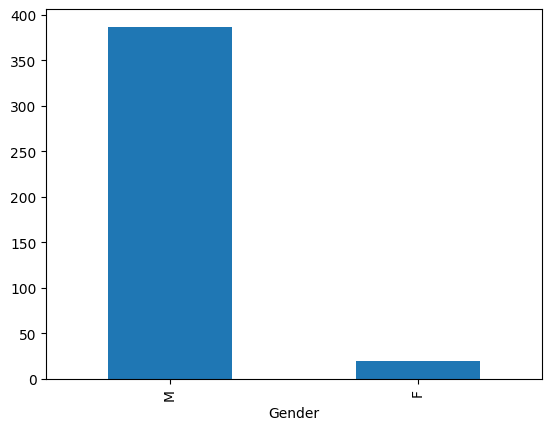

In [17]:
merged_df["Gender"].value_counts().plot(kind = "bar")


I plotted resignations over time by gender, but it felt kind of hard to read because you could barely see the female line.

<Axes: xlabel='Resignation Year'>

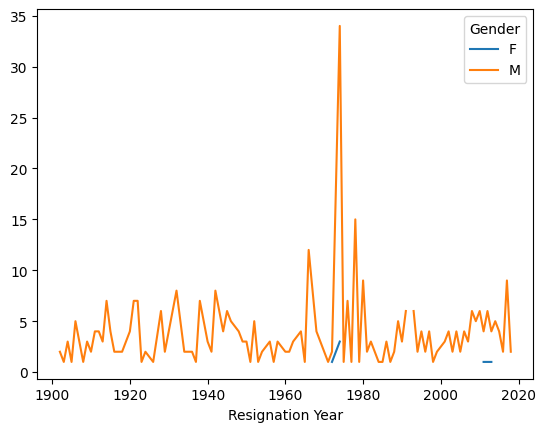

In [18]:
merged_df = merged_df.sort_values("Resignation Year")

year_gender_groupby = merged_df.groupby(["Resignation Year", "Gender"])
year_gender_groupby.size().unstack().plot()



I then plotted the just female line so that I could get a closer look at it. It looks like the peak of resignations occured in the 1970s and the 2000s. It peaked at 3 both times.

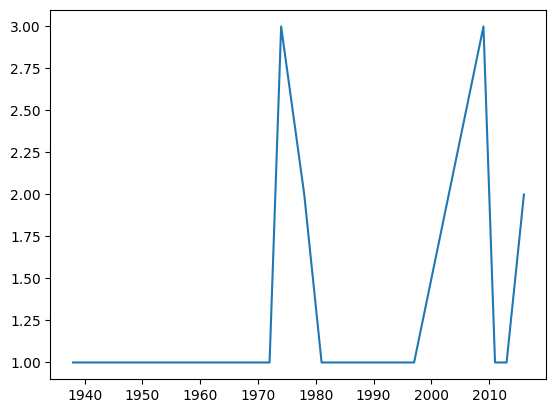

In [19]:
women = merged_df[merged_df["Gender"] == "F"]
plt.plot(women["Resignation Year"].value_counts().sort_index())


I then plotted age of resignations over time to see if age of resignation has changed over time. I also plotted number of terms overtime to see if that changed. Age of resignations has had a wide range and has bounced a lot, but has gotten older. Number of terms before resignation has grown too. The oldest member before resingation was around 88, and he also had the largest number of terms at around 27.

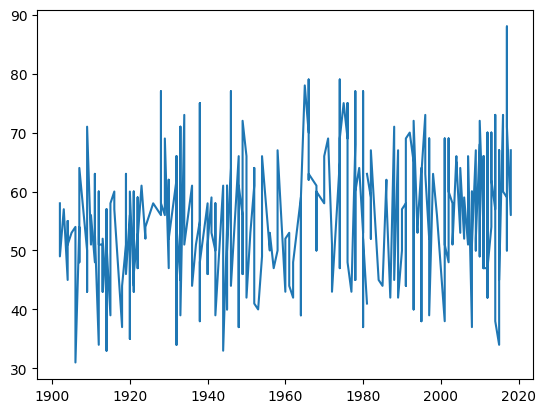

In [20]:
merged_df["Age"] = merged_df["Resignation Year"] - merged_df["Birthday"].dt.year
plt.plot(merged_df["Resignation Year"], merged_df["Age"])

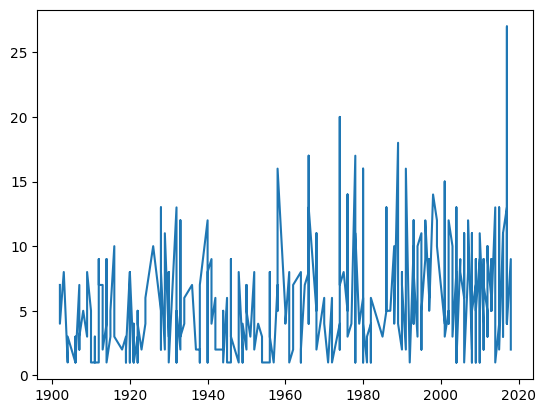

In [21]:
plt.plot(merged_df["Resignation Year"], merged_df["Num Terms"])

I graphed age and number of terms for all of congress and for just the resigners. These graphs shows that age and number of terms has increased for all of congress, not just resigners.

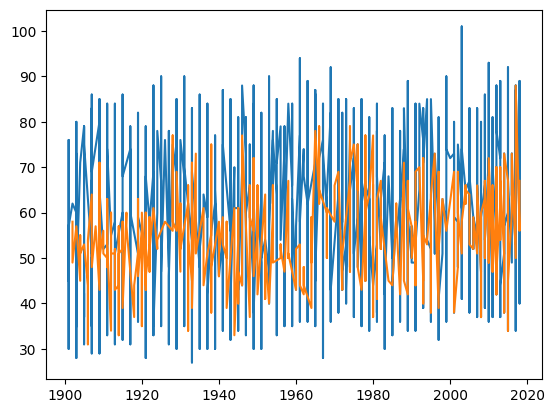

In [22]:
legislators_df["Legislators Age"] = legislators_df["End Term Year"] - legislators_df["Birthday"].dt.year

legislators_df = legislators_df.sort_values("End Term Year")

merged_df = merged_df.sort_values("Resignation Year")


legislators_df = legislators_df[(legislators_df["End Term Year"] >= 1900) & (legislators_df["End Term Year"] <= 2018)]

merged_df["Age"] = merged_df["Resignation Year"] - merged_df["Birthday"].dt.year


plt.plot(legislators_df['End Term Year'], legislators_df['Legislators Age'])
plt.plot(merged_df["Resignation Year"], merged_df["Age"])
plt.show()

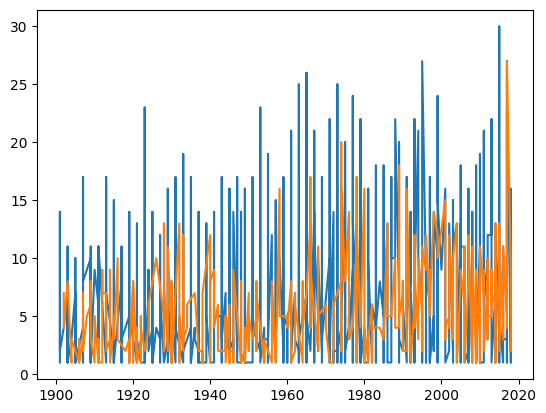

In [23]:
plt.plot(legislators_df['End Term Year'], legislators_df['Num Terms'])
plt.plot(merged_df["Resignation Year"], merged_df["Num Terms"])

I also plotted age for just female resignations and age for just female legislators so that I could compare the two. I wanted to see if resignations occured at a specific age for women and if it was different from the average age at the end of a legislators terms. It does not look like there is a specific pattern to it. The age bounces all over the place.

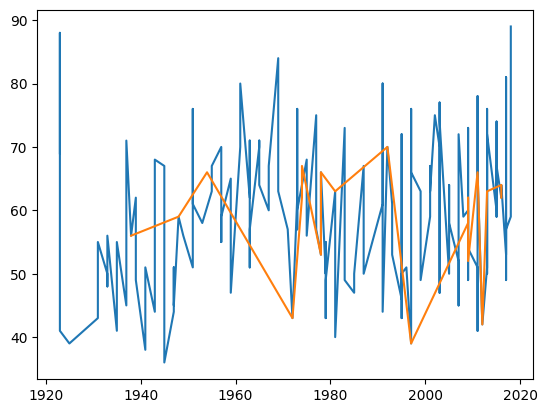

In [24]:
female_legislators = legislators_df[legislators_df['Gender'] == "F"]

female_resignations = merged_df[merged_df["Gender"] == "F"]

plt.plot(female_legislators['End Term Year'], female_legislators['Legislators Age'], label='Female Legislators')
plt.plot(female_resignations["Resignation Year"], female_resignations["Age"], label='Female Resignations')





I did a groupby to see how many of each part have resigned for each gender. It showed that democrats had resigned more for both men and women.

In [25]:
merged_df.groupby(["Party", "Gender"]).size().unstack()

Gender,F,M
Party,,
D,15,209
R,5,178


I did a crosstab of category and pattern, and it showed me a lot of interesting information. For both democrats and republicans, the most common reason for resigning is another office. Democrats have had more resignations due to unwanted sexual contact and republicans have had more resignations due to consensual sex scandals.

In [26]:
pd.crosstab(merged_df["Category"], merged_df["Party"])

Party,D,R
Category,,
Consensual sex scandals,2,7
Election overturned,4,4
Health/Family and Left early,1,0
Health/Family and Other,1,1
Health/family,7,5
Left early,48,34
Military service,4,0
Other,1,6
Other and Left early,1,1


I did a crosstab on category and gender, and that also had a lot of interesting information. No women have resigned due to scandals, just men.

In [27]:
pd.crosstab(merged_df["Category"], merged_df["Gender"])

Gender,F,M
Category,,
Consensual sex scandals,0,9
Election overturned,0,8
Health/Family and Left early,0,1
Health/Family and Other,0,2
Health/family,2,10
Left early,10,72
Military service,0,4
Other,0,7
Other and Left early,0,2


I graphed how scandals have changed over time, and that was also really interesting. It showed the big jump in scandals around watergate. It also shows that resignations for sex scandals did not really start to occur at all until the late 1970's and didn't really increase until later. It could be that sexual scandals were not occuring, but my guess is that they just were not considered resignation worthy at the time. I also think technology could have made it easier for scandals to come out.  

Text(0.5, 1.0, 'Scandals Over Time')

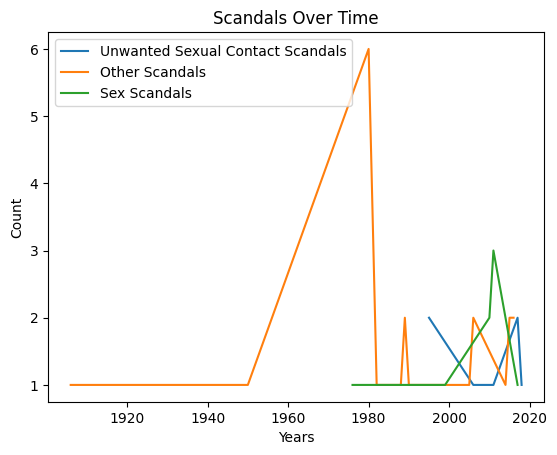

In [28]:
unwanted_sexual_contact = merged_df[merged_df["Category"] == "Unwanted sexual contact"]

plt.plot(unwanted_sexual_contact["Resignation Year"].value_counts().sort_index(), label = "Unwanted Sexual Contact Scandals")

unwanted_sexual_contact

sex_scandal = merged_df[merged_df["Category"] == "Consensual sex scandals"]

other_scandal = merged_df[merged_df["Category"] == "Other scandals"]

plt.plot(other_scandal["Resignation Year"].value_counts().sort_index(), label = "Other Scandals")

plt.plot(sex_scandal["Resignation Year"].value_counts().sort_index(), label = "Sex Scandals")

plt.legend()

plt.xlabel("Years")
plt.ylabel("Count")
plt.title("Scandals Over Time")






I made a bar graph to show how resignations varied over different states. It shows that New York and California have had the most resignations.

<Axes: ylabel='State'>

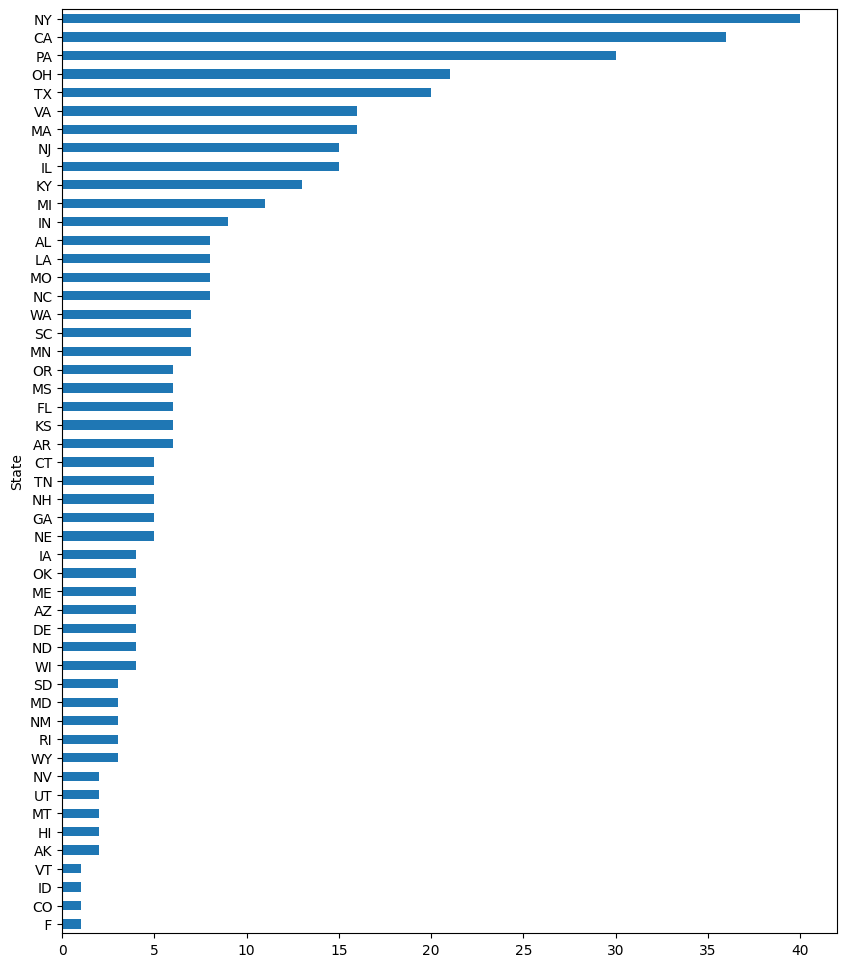

In [29]:
merged_df

merged_df["State"] = merged_df["District"].str[:2]

merged_df

plt.figure(figsize=(10, 12))



resignation_counts = merged_df["State"].value_counts().sort_values(ascending=True)

resignation_counts.plot(kind="barh")






#Models

One model I could build would be a classification model where it predicts democrat or republican. The dependent variable would be the party, and the independent variables would include age, state, gender, year of resignation, and category of resignation. I would use a K nearest neighbors model to do this. I will also test the model with cross-validation testing with the accuracy.

I started with using Number of Terms, Age, State, Gender, Resignation Year, and Category as my independent variables. I started with 10 neighbors. My first goal was to test the accuarcy and how it changed with each of my variables.

In [30]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score

merged_df = merged_df.dropna()
merged_df



features = [ "Num Terms", "Age", "State", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")

print("Accuracy score with all the X variables: {}".format(np.mean(accuracy_scores)))

features = [ "Age", "State", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_nonumterms = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without Num Terms: {}".format(np.mean(accuracy_scores_nonumterms)))
#accuracy goes up once num terms is removed

features = [ "Num Terms", "State", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_noage = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without Age: {}".format(np.mean(accuracy_scores_noage)))
#Accuracy goes up once age is removed as well



features = ["State", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_noboth = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without Num Terms and Age: {}".format(np.mean(accuracy_scores_noboth)))
#Accuracy acctually goes down a little without both of them

merged_df["Terms per Age"] = merged_df["Num Terms"] / merged_df["Age"]

features = ["Terms per Age", "State", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_Termsperage = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score with Terms per age: {}".format(np.mean(accuracy_scores_Termsperage)))

##Include age instead of num terms since accuracy increased less when age was removed.

print("Acurracy score with age: {}".format(np.mean(accuracy_scores_nonumterms)))


features = ["Age", "Gender", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_nostate = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without state: {}".format(np.mean(accuracy_scores_nostate)))
#Accuracy went down without including state.

features = ["Age", "State", "Resignation Year", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_nogender = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without gender: {}".format(np.mean(accuracy_scores_nogender)))
#Accuracy score goes down from the one that included age and did not have num terms. This means that gender should be included.

features = ["Age", "State", "Gender", "Category"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_noresyear = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without resignation year: {}".format(np.mean(accuracy_scores_noresyear)))
#Accuracy score went down when resignation year was removed. This means that it should be included.

features = ["Age", "State", "Gender", "Resignation Year"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=10))
])

accuracy_scores_nocategory = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score without category: {}".format(np.mean(accuracy_scores_nocategory)))
#Accuracy increases with no category, so it should be removed













Accuracy score with all the X variables: 0.5467931345980126
Accuracy score without Num Terms: 0.5639566395663956
Accuracy score without Age: 0.5542607648298705
Accuracy score without Num Terms and Age: 0.5418247515808491
Accuracy score with Terms per age: 0.5418849744052997
Acurracy score with age: 0.5639566395663956
Accuracy score without state: 0.5244805781391146
Accuracy score without gender: 0.5467630231857873
Accuracy score without resignation year: 0.5466124661246613
Accuracy score without category: 0.5713339355615779


The variables that ended up in my features are age, state, gender, and resignation year. My next step was to find the right number of neighbors to use to get me the highest accuracy.

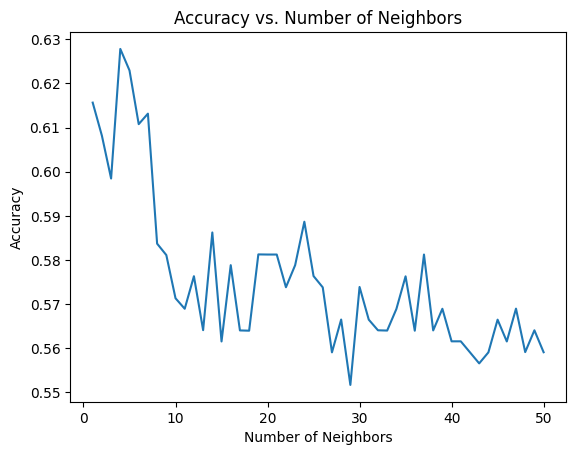

In [31]:
features = ["Age", "State", "Gender", "Resignation Year"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")


def get_val_accuracy(k):
    #model = KNeighborsClassifier(n_neighbors=k)
    pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=k))])
    val_accuracy = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
    return np.mean(val_accuracy)

accuracy = []
values = []

for i in range(1,51):
  val_accuracy = get_val_accuracy(i)
  accuracy.append(val_accuracy)
  values.append(i)

plt.plot(values, accuracy)
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Neighbors")
plt.show()



The number of neighbors that has the highest accuracy is 4.

In [32]:
features = ["Age", "State", "Gender", "Resignation Year"]
y = merged_df["Party"]

X_dict = merged_df[features].to_dict(orient="records")

pipeline = Pipeline([
    ("vectorizer", DictVectorizer(sparse=False)),
    ("scaler", StandardScaler()),
    ("fit", KNeighborsClassifier(n_neighbors=4))
])

accuracy_scores_nocategory = cross_val_score(pipeline, X_dict, y,
                         cv=5, scoring="accuracy")
print("Accuracy score with 4 Nearest Neighbors: {}".format(np.mean(accuracy_scores_nocategory)))

Accuracy score with 4 Nearest Neighbors: 0.6278229448961156


I could also do a regression model that predicts age at resignation. In this case, age would be the dependent variable, and the independent variables would be age, state, gender, year of resignation, and category of resignation. I would also use a k-nearest neighbors model to do this. I will also test the model with cross-validation testing with the mean absolute error,  

In [33]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/Colab_Notebooks/Grossman_FinalTutorial.ipynb







[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab_Notebooks/Grossman_FinalTutorial.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 14 image(s).
[NbConvertApp] Writing 1132187 bytes to /content/drive/MyDrive/Colab_Notebooks/Grossman_FinalTutorial.html
